In [16]:
#Here we will find a conventional treatment plan for real patient to make sure it makes sense
#Also, will check and incorporate smoothing

In [2]:
import numpy as np
import scipy.optimize
import pandas as pd
import operator
import scipy.io
import scipy
import scipy.sparse
import time
import sys

In [3]:
sys.path.append('/home/rilevin/MMORT/mmort')
from optimization_tools import *
from experiments import *

In [4]:
data = scipy.io.loadmat('data/ProstateExample_BODY_not_reduced_with_OAR_constraints.mat')
Alpha = np.array([0.35, 0.35])
Beta = np.array([0.175, 0.175])
Gamma = np.array([np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35])               
                 ])
Delta = np.array([np.array([0.07, 0.07]),
                  np.array([0.07, 0.07]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175])                
                 ])
modality_names = np.array(['Aphoton', 'Aproton'])

In [5]:
solver?

In [6]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [7]:
#redo this one
def objective_N(N,  Alpha = Alpha, Beta = Beta, Gamma = Gamma, Delta = Delta, data = data, modality_names = modality_names):
    T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
    num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
    #Assuming N>0, and two-modality case
    Rx = 80
    LHS1 = T_list[0]
    LHS2 = T_list[1]
    RHS1 = np.array([Rx/(np.sum(N))]*LHS1.shape[0])
    RHS2 = np.array([Rx/(np.sum(N))]*LHS2.shape[0])

    print('I am HERE')
    u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-4, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
    u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-4, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)
    
    
    u_init11 = np.concatenate([u1_guess, u2_guess])
#     u_init11 = 10*np.ones(2289+16358)
    print("GOT HERE!")
    u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.1, ftol = 1e-3, max_iter = 300, verbose = 1)
    
    return obj_u_opt_N_opt(u, T, alpha, B, N, num_tumor_voxels, Td = 10)

def informative_objective_N(N,  Alpha = Alpha, Beta = Beta, Gamma = Gamma, Delta = Delta, data = data, modality_names = modality_names):
    T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
    num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
    #Assuming N>0, and two-modality case
    Rx = 80
    LHS1 = T_list[0]
    LHS2 = T_list[1]
    RHS1 = np.array([Rx/(np.sum(N))]*LHS1.shape[0])
    RHS2 = np.array([Rx/(np.sum(N))]*LHS2.shape[0])

#     u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-1, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
#     u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-1, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)
    
#     u_init11 = np.concatenate([u1_guess, u2_guess])
#     u_init11 = 10*np.ones(2289+16358)
    u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 1)
    
    return u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history, obj_u_opt_N_opt(u, T, alpha, B, N, num_tumor_voxels, Td = 10)



def optimize_N(N_init, N_SUM_MAX = 45, max_iter = 6):
    """Value function of N optimization as per Algorithm 1 of the paper.
    Uses trust-region-constrained from scipy

    Parameters
    ----------
    N_init : np.array of shape (M,), where M is the number of modalities
        Initial array of fractions
    N_SUM_MAX : float
        Max treatment course length, the bound on the sum of N
    max_iter : int
        Max number of iterations

    Returns
    -------
    x : np.array of shape (M,)
        Optimal fractionation schedule N
    res : OptimizationResult from scipy
        Metadata of the algorithm
    Nk_hist : list
        Iterates N history 
    """
    Nk_hist = []
    def callback(xk, OptRes):
        Nk_hist.append(xk)
        return 0

    bounds =  scipy.optimize.Bounds([1, 1], [np.inf, np.inf]) #or 0,0
    linear_constraint = scipy.optimize.LinearConstraint(np.array([1,1]), -np.inf, N_SUM_MAX)
   
    x0 = np.array(N_init)
    res = scipy.optimize.minimize(objective_N, x0, method='trust-constr',  jac="2-point", hess=BFGS(), 
                         constraints=[linear_constraint], options={'verbose': 4, 'maxiter': max_iter}, bounds=bounds, 
                         callback = callback)
    x = res.x
    print('NEW N rounded:', np.rint(x), 'EXACT new N:', x)
    return x, res, obj_Nk_hist, Nk_hist


In [9]:
T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(np.array([43,1]), Alpha, Beta, Gamma, Delta, data, modality_names)
# u_init = 10*np.ones(2289+16358)

getting through 11912 matrices


In [10]:
#     T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
#     num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
#Assuming N>0, and two-modality case
N = np.array([43, 1])
Rx = 80
LHS1 = T_list[0]
LHS2 = T_list[1]
RHS1 = np.array([Rx/np.sum(N)]*LHS1.shape[0])
RHS2 = np.array([Rx/np.sum(N)]*LHS2.shape[0])

print('I am HERE')
u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)


I am HERE
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.7695e-01, final cost 1.2601e-01, first-order optimality 6.71e-03.
The first-order optimality measure is less than `tol`.
Number of iterations 7, initial cost 1.1198e+00, final cost 7.1103e-01, first-order optimality 8.94e-04.


In [11]:
u_init11 = np.concatenate([u1_guess, u2_guess])
#u_init11 = np.concatenate([u_conv, np.zeros(u2_guess.shape[0])]) 

In [12]:
# solver_auto_param(u_init, T, H, L_lhs, L_rhs, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 0)

In [13]:
smoothing = scipy.io.loadmat('smoothing_matrix.mat')
smoothing_matrix = smoothing['sm_matrix']
L_lhs = scipy.sparse.csc_matrix(smoothing_matrix)
L_rhs = np.zeros(L_lhs.shape[0])

In [14]:
L_lhs.shape

(79216, 2289)

In [15]:
T.shape

(13564, 18647)

In [45]:
u_mult, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, L_lhs, L_rhs, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 1)

ValueError: blocks[:,0] has incompatible row dimensions. Got blocks[11912,0].shape[1] == 2289, expected 18647.

In [16]:
%%time
T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(np.array([45,0]), Alpha, Beta, Gamma, Delta, data, modality_names)
# u_init = 10*np.ones(2289+16358)

getting through 11912 matrices
CPU times: user 5min 16s, sys: 2 s, total: 5min 18s
Wall time: 5min 5s


In [30]:
Lhs_array = []
for i in range(1,6):
    smoothing = scipy.io.loadmat('sm_matrix_' + str(i) + '.mat')
    smoothing_matrix = smoothing['sm_matrices_' + str(i)]
    Lhs_array.append(smoothing_matrix)
L_lhs = scipy.sparse.block_diag(Lhs_array, format='csc')
#     L_lhs = scipy.sparse.csc_matrix(smoothing_matrix)
L_rhs = np.zeros(L_lhs.shape[0])

In [25]:
#TODO: smooth separately, by beams -> reduces the matrix
%%time
u_conv, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u1_guess, T, H, L_lhs, L_rhs, alpha, gamma, B, D, C, eta_step = 0.1, ftol = 1e-3, max_iter = 100, verbose = 1)

The relative change of the cost function is less than `tol`.
Number of iterations 7, initial cost 8.3332e+05, final cost 7.0143e+05, first-order optimality 9.06e+03.
    iter = 1, stopping criterion:2404139.4223531485, OBJ -242385.1461064663
    This iteration took: 7.235089063644409
The relative change of the cost function is less than `tol`.
Number of iterations 9, initial cost 4.3601e+05, final cost 3.2049e+05, first-order optimality 3.43e+03.
    iter = 2, stopping criterion:1.033064022574366, OBJ -236697.90404468958
    This iteration took: 6.497190952301025
The relative change of the cost function is less than `tol`.
Number of iterations 9, initial cost 4.2244e+05, final cost 3.0145e+05, first-order optimality 2.78e+03.
    iter = 3, stopping criterion:0.03138770701464431, OBJ -235369.14175848782
    This iteration took: 6.203841209411621
The relative change of the cost function is less than `tol`.
Number of iterations 7, initial cost 4.2436e+05, final cost 2.9856e+05, first-orde

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The unconstrained solution is optimal.
Final cost 3.1239e+05, first-order optimality 1.05e+03
    iter = 4, stopping criterion:0.01738943188680303, OBJ -248526.31984681252
    This iteration took: 3.997387170791626
The relative change of the cost function is less than `tol`.
Number of iterations 7, initial cost 4.1709e+05, final cost 3.1695e+05, first-order optimality 4.53e+03.
    iter = 5, stopping criterion:0.003005610037640722, OBJ -250400.5948875129
    This iteration took: 5.3335487842559814
The unconstrained solution is optimal.
Final cost 3.1813e+05, first-order optimality 1.13e+03
    iter = 6, stopping criterion:0.009885876826011625, OBJ -252222.59187572077
    This iteration took: 3.9052462577819824
The relative change of the cost function is less than `tol`.
Number of iterations 7, initial cost 4.2196e+05, final cost 3.2113e+05, first-order optimality 4.43e+03.
    iter = 7, stopping criterion:0.0024469520815045198, OBJ -253840.5869150103
    This iteration took: 5.31075334

    iter = 17, stopping criterion:0.0017312826825736458, OBJ -259425.6688637827
    This iteration took: 3.6720664501190186
The relative change of the cost function is less than `tol`.
Number of iterations 5, initial cost 3.5093e+05, final cost 3.3333e+05, first-order optimality 1.32e+03.
    iter = 18, stopping criterion:0.0014652792847969262, OBJ -259632.14694522854
    This iteration took: 4.542478322982788
The unconstrained solution is optimal.
Final cost 3.3374e+05, first-order optimality 8.86e+02
    iter = 19, stopping criterion:2.3841440273027184e-05, OBJ -259636.53309545384
    This iteration took: 3.6781020164489746
Iter  3 # of violated constr: 1
The unconstrained solution is optimal.
Final cost 4.4699e+05, first-order optimality 2.48e+03
    iter = 1, stopping criterion:3047891.9591474743, OBJ -258055.0863037468
    This iteration took: 2.8813581466674805
The unconstrained solution is optimal.
Final cost 4.0182e+05, first-order optimality 2.47e+03
    iter = 2, stopping cri

The unconstrained solution is optimal.
Final cost 3.3185e+05, first-order optimality 1.79e+03
    iter = 7, stopping criterion:0.0143286834900169, OBJ -249658.05503713095
    This iteration took: 2.5597729682922363
The unconstrained solution is optimal.
Final cost 3.2856e+05, first-order optimality 1.79e+03
    iter = 8, stopping criterion:0.01198395070555734, OBJ -249512.8447189771
    This iteration took: 2.5556046962738037
The unconstrained solution is optimal.
Final cost 3.2573e+05, first-order optimality 1.79e+03
    iter = 9, stopping criterion:0.010133977452171036, OBJ -249379.23327386737
    This iteration took: 2.5217230319976807
The unconstrained solution is optimal.
Final cost 3.2327e+05, first-order optimality 1.79e+03
    iter = 10, stopping criterion:0.008658757464387375, OBJ -249256.79382392092
    This iteration took: 2.6320629119873047
The unconstrained solution is optimal.
Final cost 3.2111e+05, first-order optimality 1.79e+03
    iter = 11, stopping criterion:0.00746

The unconstrained solution is optimal.
Final cost 3.0550e+05, first-order optimality 4.64e+03
    iter = 16, stopping criterion:0.0011523589478420657, OBJ -247768.3829655619
    This iteration took: 2.50542950630188
The unconstrained solution is optimal.
Final cost 3.0517e+05, first-order optimality 4.64e+03
    iter = 17, stopping criterion:0.0009898663130978945, OBJ -247737.9430260295
    This iteration took: 2.5872819423675537
Iter  6 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 7.7900e+05, first-order optimality 1.43e+06
    iter = 1, stopping criterion:4068193.3437343533, OBJ -247074.3054653412
    This iteration took: 2.0183804035186768
The unconstrained solution is optimal.
Final cost 6.2325e+05, first-order optimality 9.71e+05
    iter = 2, stopping criterion:0.759171737464116, OBJ -246623.873327926
    This iteration took: 2.0832736492156982
The unconstrained solution is optimal.
Final cost 6.5986e+05, first-order optimality 9.

The unconstrained solution is optimal.
Final cost 8.0575e+05, first-order optimality 9.51e+05
    iter = 37, stopping criterion:0.0037586603206861504, OBJ -234283.92440384827
    This iteration took: 2.278773069381714
The unconstrained solution is optimal.
Final cost 8.0592e+05, first-order optimality 9.50e+05
    iter = 38, stopping criterion:0.003413159803923833, OBJ -233928.64858926117
    This iteration took: 2.082165002822876
The unconstrained solution is optimal.
Final cost 8.0594e+05, first-order optimality 9.48e+05
    iter = 39, stopping criterion:0.002848178995567909, OBJ -233572.7322462443
    This iteration took: 2.1447901725769043
The unconstrained solution is optimal.
Final cost 8.0589e+05, first-order optimality 9.46e+05
    iter = 40, stopping criterion:0.0025482080108366113, OBJ -233216.05022614423
    This iteration took: 2.0967984199523926
The unconstrained solution is optimal.
Final cost 8.0577e+05, first-order optimality 9.44e+05
    iter = 41, stopping criterion:0

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 6.7264e+07, final cost 7.0223e+06, first-order optimality 7.82e+05.
    iter = 18, stopping criterion:0.15334345369729838, OBJ -222575.40518049715
    This iteration took: 10.728031635284424
The unconstrained solution is optimal.
Final cost 7.7715e+06, first-order optimality 2.16e+07
    iter = 19, stopping criterion:0.11517872094773891, OBJ -221869.04896049373
    This iteration took: 2.1132099628448486
The unconstrained solution is optimal.
Final cost 5.9090e+06, first-order optimality 1.50e+07
    iter = 20, stopping criterion:0.25683993549251977, OBJ -221310.15758612473
    This iteration took: 2.02254056930542
The unconstrained solution is optimal.
Final cost 6.1114e+06, first-order optimality 1.51e+07
    iter = 21, stopping criterion:0.03780491652486156, OBJ -220753.18686463544
    This iteration took: 1.958094835281372
The maximum number of iterations is exceeded.
Number of iterations 30, initia

    iter = 53, stopping criterion:0.09484791906797559, OBJ -208894.68340337963
    This iteration took: 10.18114423751831
The unconstrained solution is optimal.
Final cost 7.0215e+06, first-order optimality 2.15e+07
    iter = 54, stopping criterion:0.18213103157666838, OBJ -208067.1955017735
    This iteration took: 1.9943218231201172
The unconstrained solution is optimal.
Final cost 5.4340e+06, first-order optimality 1.48e+07
    iter = 55, stopping criterion:0.24309646859396403, OBJ -207417.73756908247
    This iteration took: 2.0242021083831787
The unconstrained solution is optimal.
Final cost 5.6728e+06, first-order optimality 1.48e+07
    iter = 56, stopping criterion:0.04861882249303709, OBJ -206778.0579288343
    This iteration took: 1.940983533859253
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 5.7243e+07, final cost 6.1052e+06, first-order optimality 9.01e+05.
    iter = 57, stopping criterion:0.0837541176536265, OBJ -207183.81479100126


The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.4012e+07, final cost 3.0024e+06, first-order optimality 3.82e+05.
    iter = 88, stopping criterion:0.5571301484027245, OBJ -198258.31176389725
    This iteration took: 9.232466220855713
The unconstrained solution is optimal.
Final cost 6.1509e+06, first-order optimality 2.04e+07
    iter = 89, stopping criterion:1.2459716952028894, OBJ -197379.16464507105
    This iteration took: 2.0331501960754395
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.4211e+07, final cost 3.0374e+06, first-order optimality 5.75e+05.
    iter = 90, stopping criterion:0.5483868578362432, OBJ -197714.76398317196
    This iteration took: 9.982435703277588
The unconstrained solution is optimal.
Final cost 6.1122e+06, first-order optimality 2.03e+07
    iter = 91, stopping criterion:1.1996258581399126, OBJ -196833.5034647875
    This iteration took: 2.5024001598358154
The maximum number of i

    iter = 121, stopping criterion:0.5763561676278225, OBJ -188360.6527377707
    This iteration took: 1.9151496887207031
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.9402e+07, final cost 3.1504e+06, first-order optimality 4.50e+05.
    iter = 122, stopping criterion:0.46591439962696446, OBJ -188696.54587688693
    This iteration took: 9.862542390823364
The unconstrained solution is optimal.
Final cost 5.4640e+06, first-order optimality 1.92e+07
    iter = 123, stopping criterion:0.8586884764384707, OBJ -187789.88117611632
    This iteration took: 1.702204942703247
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.8599e+07, final cost 2.2462e+06, first-order optimality 3.15e+05.
    iter = 124, stopping criterion:0.6423541788831317, OBJ -188086.4339350817
    This iteration took: 9.89146375656128
The unconstrained solution is optimal.
Final cost 5.4670e+06, first-order optimality 1.91e+07
    iter = 125, stopp

The unconstrained solution is optimal.
Final cost 4.9544e+06, first-order optimality 1.79e+07
    iter = 155, stopping criterion:1.118049276020289, OBJ -178153.77735962934
    This iteration took: 1.903801441192627
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.2245e+07, final cost 2.6258e+06, first-order optimality 3.94e+05.
    iter = 156, stopping criterion:0.5152124789492374, OBJ -178455.94179176504
    This iteration took: 10.809427261352539
The unconstrained solution is optimal.
Final cost 4.9173e+06, first-order optimality 1.79e+07
    iter = 157, stopping criterion:1.046341345211484, OBJ -177543.0051088903
    This iteration took: 1.9801292419433594
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.1993e+07, final cost 2.8101e+06, first-order optimality 4.14e+05.
    iter = 158, stopping criterion:0.4699278671656757, OBJ -177856.52985026874
    This iteration took: 9.857431173324585
The unconstrained sol

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.5220e+07, final cost 3.3195e+06, first-order optimality 5.79e+05.
    iter = 189, stopping criterion:0.3136573338531603, OBJ -167172.04636066532
    This iteration took: 10.018667936325073
The unconstrained solution is optimal.
Final cost 4.4843e+06, first-order optimality 1.65e+07
    iter = 190, stopping criterion:0.40063925479919676, OBJ -166286.7729551645
    This iteration took: 1.986177921295166
The unconstrained solution is optimal.
Final cost 5.1085e+06, first-order optimality 1.63e+07
    iter = 191, stopping criterion:0.1538222108507446, OBJ -165460.54482948012
    This iteration took: 2.0904476642608643
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.9558e+07, final cost 3.8922e+06, first-order optimality 4.30e+05.
    iter = 192, stopping criterion:0.2586702607721165, OBJ -165828.90866898233
    This iteration took: 10.058578491210938
The unconstrained

    iter = 223, stopping criterion:0.006019827251408965, OBJ -153825.85809731492
    This iteration took: 2.0276005268096924
The unconstrained solution is optimal.
Final cost 4.4984e+06, first-order optimality 1.47e+07
    iter = 224, stopping criterion:0.15450409713110716, OBJ -153031.88343536074
    This iteration took: 1.967658519744873
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.7143e+07, final cost 3.8583e+06, first-order optimality 4.32e+05.
    iter = 225, stopping criterion:0.1553354610729067, OBJ -153394.67083845777
    This iteration took: 10.159996747970581
The unconstrained solution is optimal.
Final cost 3.9471e+06, first-order optimality 1.48e+07
    iter = 226, stopping criterion:0.025373414617942364, OBJ -152563.00636597307
    This iteration took: 2.1916046142578125
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.1679e+07, final cost 2.7458e+06, first-order optimality 3.94e+05.
    iter = 2

The unconstrained solution is optimal.
Final cost 7.2059e+06, first-order optimality 2.02e+07
    iter = 257, stopping criterion:1.247187944057789, OBJ -143023.9447619683
    This iteration took: 1.9250481128692627
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.7129e+07, final cost 3.6826e+06, first-order optimality 1.01e+06.
    iter = 258, stopping criterion:0.5149905415342293, OBJ -143357.2634258331
    This iteration took: 9.919917345046997
The unconstrained solution is optimal.
Final cost 7.1764e+06, first-order optimality 2.01e+07
    iter = 259, stopping criterion:1.0532877393186673, OBJ -142426.89846978703
    This iteration took: 1.9508941173553467
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.7096e+07, final cost 3.5292e+06, first-order optimality 9.82e+05.
    iter = 260, stopping criterion:0.5353244950499539, OBJ -142754.52194347585
    This iteration took: 10.697700262069702
The unconstrained so

    iter = 290, stopping criterion:0.463183987506807, OBJ -133849.4569310152
    This iteration took: 10.126933097839355
The unconstrained solution is optimal.
Final cost 6.5377e+06, first-order optimality 1.83e+07
    iter = 291, stopping criterion:0.8469288810924996, OBJ -132924.67298260468
    This iteration took: 1.958867073059082
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.8226e+07, final cost 3.4379e+06, first-order optimality 3.79e+05.
    iter = 292, stopping criterion:0.5004887868300627, OBJ -133253.68960590777
    This iteration took: 10.15697717666626
The unconstrained solution is optimal.
Final cost 6.4943e+06, first-order optimality 1.81e+07
    iter = 293, stopping criterion:0.9883050384638384, OBJ -132329.88383078462
    This iteration took: 1.9172818660736084
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.8508e+07, final cost 3.3311e+06, first-order optimality 9.66e+05.
    iter = 294, stop

    iter = 24, stopping criterion:0.4714492929315889, OBJ -124503.61006230483
    This iteration took: 9.947084665298462
The unconstrained solution is optimal.
Final cost 5.2584e+07, first-order optimality 1.63e+08
    iter = 25, stopping criterion:0.8705053814547947, OBJ -123658.03933127849
    This iteration took: 1.8590776920318604
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.7284e+08, final cost 4.8213e+07, first-order optimality 6.04e+06.
    iter = 26, stopping criterion:0.08362074235935418, OBJ -124035.44815468742
    This iteration took: 9.817363739013672
The unconstrained solution is optimal.
Final cost 5.1651e+07, first-order optimality 1.62e+08
    iter = 27, stopping criterion:0.07178504680389783, OBJ -123191.11353855091
    This iteration took: 1.958289384841919
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.2974e+08, final cost 2.6740e+07, first-order optimality 9.34e+06.
    iter = 28, stoppi

    iter = 58, stopping criterion:0.40203417026108246, OBJ -115849.22107563922
    This iteration took: 10.706620216369629
The unconstrained solution is optimal.
Final cost 3.9599e+07, first-order optimality 1.43e+08
    iter = 59, stopping criterion:0.6376818975431675, OBJ -115073.93621343674
    This iteration took: 2.1235907077789307
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.4528e+08, final cost 2.5035e+07, first-order optimality 6.34e+06.
    iter = 60, stopping criterion:0.37066324604410844, OBJ -115370.6172721051
    This iteration took: 10.207051277160645
The unconstrained solution is optimal.
Final cost 3.8742e+07, first-order optimality 1.42e+08
    iter = 61, stopping criterion:0.5543442885085975, OBJ -114600.961541347
    This iteration took: 1.9276599884033203
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.4173e+08, final cost 2.2179e+07, first-order optimality 3.73e+06.
    iter = 62, stoppi

    iter = 92, stopping criterion:0.4734881524233742, OBJ -108313.30510134979
    This iteration took: 11.03191351890564
The unconstrained solution is optimal.
Final cost 2.9608e+07, first-order optimality 1.26e+08
    iter = 93, stopping criterion:0.878532190661535, OBJ -107636.22009360325
    This iteration took: 2.180246353149414
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.3808e+08, final cost 1.7383e+07, first-order optimality 3.66e+06.
    iter = 94, stopping criterion:0.41705026722906136, OBJ -107899.04429208749
    This iteration took: 10.375398635864258
The unconstrained solution is optimal.
Final cost 2.9291e+07, first-order optimality 1.25e+08
    iter = 95, stopping criterion:0.6968656787680948, OBJ -107228.29061646454
    This iteration took: 2.0350213050842285
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.4461e+08, final cost 1.7673e+07, first-order optimality 3.51e+06.
    iter = 96, stoppin

    iter = 126, stopping criterion:0.2960035764699706, OBJ -101408.99154876292
    This iteration took: 10.009456872940063
The unconstrained solution is optimal.
Final cost 6.6105e+07, first-order optimality 1.43e+08
    iter = 127, stopping criterion:2.137263385081377, OBJ -100594.01047334119
    This iteration took: 1.8823935985565186
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.5927e+08, final cost 2.8617e+07, first-order optimality 4.00e+06.
    iter = 128, stopping criterion:0.5695159755100584, OBJ -100935.54574275392
    This iteration took: 10.814387559890747
The unconstrained solution is optimal.
Final cost 6.6654e+07, first-order optimality 1.42e+08
    iter = 129, stopping criterion:1.3423439460649202, OBJ -100123.08793303337
    This iteration took: 1.943244218826294
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.7338e+08, final cost 3.0268e+07, first-order optimality 3.96e+06.
    iter = 130, st

    iter = 160, stopping criterion:0.23502879748212815, OBJ -94588.89352175237
    This iteration took: 10.06362247467041
The unconstrained solution is optimal.
Final cost 6.5554e+07, first-order optimality 1.34e+08
    iter = 161, stopping criterion:1.7070246483731075, OBJ -93789.01831720381
    This iteration took: 1.8456950187683105
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.8354e+08, final cost 2.9455e+07, first-order optimality 3.87e+06.
    iter = 162, stopping criterion:0.5529256496607085, OBJ -94132.34931588368
    This iteration took: 10.703355312347412
The unconstrained solution is optimal.
Final cost 6.6578e+07, first-order optimality 1.35e+08
    iter = 163, stopping criterion:1.2718713467442184, OBJ -93333.81997229788
    This iteration took: 1.9589927196502686
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 5.0089e+08, final cost 3.0015e+07, first-order optimality 3.81e+06.
    iter = 164, stop

    iter = 194, stopping criterion:0.4083460086273238, OBJ -88114.14843872159
    This iteration took: 10.124527931213379
The unconstrained solution is optimal.
Final cost 5.8810e+07, first-order optimality 1.30e+08
    iter = 195, stopping criterion:0.6458511816503664, OBJ -87362.64527484197
    This iteration took: 1.889622449874878
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 5.7267e+08, final cost 3.0888e+07, first-order optimality 3.77e+06.
    iter = 196, stopping criterion:0.47684321041045774, OBJ -87716.14781210088
    This iteration took: 9.975874662399292
The unconstrained solution is optimal.
Final cost 5.6996e+07, first-order optimality 1.29e+08
    iter = 197, stopping criterion:0.8522840782730237, OBJ -86974.44233673322
    This iteration took: 1.9718570709228516
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 5.7841e+08, final cost 4.8699e+07, first-order optimality 5.42e+06.
    iter = 198, stopp

    iter = 228, stopping criterion:0.008480958053796027, OBJ -83032.76113952053
    This iteration took: 10.085782051086426
The unconstrained solution is optimal.
Final cost 3.4851e+07, first-order optimality 1.33e+08
    iter = 229, stopping criterion:0.014927819875143095, OBJ -82431.76363588033
    This iteration took: 1.9085028171539307
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.4076e+08, final cost 1.9446e+07, first-order optimality 3.49e+06.
    iter = 230, stopping criterion:0.4451420111624298, OBJ -82733.35625925573
    This iteration took: 9.942546367645264
The unconstrained solution is optimal.
Final cost 3.4095e+07, first-order optimality 1.33e+08
    iter = 231, stopping criterion:0.7629349501536449, OBJ -82142.77291632605
    This iteration took: 2.153273582458496
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.5871e+08, final cost 2.0259e+07, first-order optimality 3.43e+06.
    iter = 232, st

    iter = 262, stopping criterion:0.2971760675879896, OBJ -79406.24480563763
    This iteration took: 10.789955854415894
The unconstrained solution is optimal.
Final cost 2.6454e+07, first-order optimality 1.40e+08
    iter = 263, stopping criterion:0.404415672717567, OBJ -78922.91609022646
    This iteration took: 1.8560259342193604
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.4111e+08, final cost 2.3281e+07, first-order optimality 4.54e+06.
    iter = 264, stopping criterion:0.12102743337313397, OBJ -79328.95123669734
    This iteration took: 9.852905750274658
The unconstrained solution is optimal.
Final cost 2.6060e+07, first-order optimality 1.41e+08
    iter = 265, stopping criterion:0.12059881167002344, OBJ -78847.02856512963
    This iteration took: 1.8629257678985596
The unconstrained solution is optimal.
Final cost 2.8064e+07, first-order optimality 1.38e+08
    iter = 266, stopping criterion:0.0776138203210375, OBJ -78400.10264761551


The unconstrained solution is optimal.
Final cost 3.7043e+07, first-order optimality 1.44e+08
    iter = 298, stopping criterion:0.0053207190105766244, OBJ -73013.49870200813
    This iteration took: 1.8529832363128662
The unconstrained solution is optimal.
Final cost 3.7190e+07, first-order optimality 1.44e+08
    iter = 299, stopping criterion:0.0040203947534972395, OBJ -72756.1225368292
    This iteration took: 1.9176721572875977
The unconstrained solution is optimal.
Final cost 3.7303e+07, first-order optimality 1.44e+08
    iter = 300, stopping criterion:0.0030818017231388334, OBJ -72503.11932570668
    This iteration took: 1.899282455444336
Iter  9 # of violated constr: 276
The unconstrained solution is optimal.
Final cost 3.7220e+08, first-order optimality 1.44e+09
    iter = 1, stopping criterion:7439506601.925733, OBJ -72266.81148067873
    This iteration took: 1.8096466064453125
The unconstrained solution is optimal.
Final cost 3.7264e+08, first-order optimality 1.43e+09
    

    iter = 30, stopping criterion:0.007822577443091762, OBJ -66585.47688926502
    This iteration took: 1.8676903247833252
The unconstrained solution is optimal.
Final cost 5.3132e+10, first-order optimality 1.22e+11
    iter = 31, stopping criterion:0.007845157478819044, OBJ -66449.69663137301
    This iteration took: 1.94291353225708
The unconstrained solution is optimal.
Final cost 5.2716e+10, first-order optimality 1.21e+11
    iter = 32, stopping criterion:0.00783989637600477, OBJ -66315.64221917394
    This iteration took: 1.903167724609375
The unconstrained solution is optimal.
Final cost 5.2303e+10, first-order optimality 1.21e+11
    iter = 33, stopping criterion:0.007824617557227043, OBJ -66183.28997735263
    This iteration took: 1.9560258388519287
The unconstrained solution is optimal.
Final cost 6.2354e+10, first-order optimality 1.55e+11
    iter = 34, stopping criterion:0.19215968513710158, OBJ -65938.18102123885
    This iteration took: 1.958348274230957
The unconstrain

    iter = 68, stopping criterion:0.008380797261169474, OBJ -60799.98132922714
    This iteration took: 1.918774127960205
The unconstrained solution is optimal.
Final cost 5.0267e+10, first-order optimality 1.35e+11
    iter = 69, stopping criterion:0.008234021645618086, OBJ -60679.27694158967
    This iteration took: 1.8520188331604004
The unconstrained solution is optimal.
Final cost 4.9860e+10, first-order optimality 1.34e+11
    iter = 70, stopping criterion:0.008105508325871813, OBJ -60559.81665999759
    This iteration took: 1.894153356552124
The unconstrained solution is optimal.
Final cost 4.9461e+10, first-order optimality 1.34e+11
    iter = 71, stopping criterion:0.007993483921271463, OBJ -60441.5663894625
    This iteration took: 1.8641016483306885
The unconstrained solution is optimal.
Final cost 4.9071e+10, first-order optimality 1.34e+11
    iter = 72, stopping criterion:0.00789209111540081, OBJ -60324.4951812442
    This iteration took: 1.9202265739440918
The unconstrai

    iter = 106, stopping criterion:0.007141099753457117, OBJ -56985.16413478564
    This iteration took: 1.8422372341156006
The unconstrained solution is optimal.
Final cost 3.7944e+10, first-order optimality 1.18e+11
    iter = 107, stopping criterion:0.007126911173725701, OBJ -56904.32338665608
    This iteration took: 1.8085122108459473
The unconstrained solution is optimal.
Final cost 3.7674e+10, first-order optimality 1.18e+11
    iter = 108, stopping criterion:0.007108966174471149, OBJ -56824.365712705905
    This iteration took: 1.8285813331604004
The unconstrained solution is optimal.
Final cost 3.7406e+10, first-order optimality 1.17e+11
    iter = 109, stopping criterion:0.007098152846251877, OBJ -56745.27634013099
    This iteration took: 1.7921550273895264
The unconstrained solution is optimal.
Final cost 3.7140e+10, first-order optimality 1.17e+11
    iter = 110, stopping criterion:0.007122702421271036, OBJ -56667.05456784257
    This iteration took: 1.7734081745147705
The

    iter = 143, stopping criterion:0.2940207891782492, OBJ -58630.00506662918
    This iteration took: 1.8240208625793457
The unconstrained solution is optimal.
Final cost 3.3552e+10, first-order optimality 1.19e+11
    iter = 144, stopping criterion:0.01701663307941719, OBJ -58450.93045348865
    This iteration took: 1.8534581661224365
The unconstrained solution is optimal.
Final cost 3.3459e+10, first-order optimality 1.19e+11
    iter = 145, stopping criterion:0.0027577900724110403, OBJ -58274.419107030444
    This iteration took: 1.8879454135894775
The unconstrained solution is optimal.
Final cost 3.3449e+10, first-order optimality 1.18e+11
    iter = 146, stopping criterion:0.00030317866401561173, OBJ -58100.26740407212
    This iteration took: 1.8265316486358643
Iter  12 # of violated constr: 102
The unconstrained solution is optimal.
Final cost 3.3414e+11, first-order optimality 1.17e+12
    iter = 1, stopping criterion:6682715433500.008, OBJ -57924.93526973952
    This iteratio

    iter = 3, stopping criterion:0.8110886078498482, OBJ -57032.302819266246
    This iteration took: 9.926421403884888
The unconstrained solution is optimal.
Final cost 3.9406e+13, first-order optimality 1.32e+14
    iter = 4, stopping criterion:0.25774245011504177, OBJ -56629.178767486155
    This iteration took: 1.7487804889678955
The unconstrained solution is optimal.
Final cost 4.4116e+13, first-order optimality 1.30e+14
    iter = 5, stopping criterion:0.1195284657781911, OBJ -56240.965185830835
    This iteration took: 1.8298354148864746
The unconstrained solution is optimal.
Final cost 3.0503e+13, first-order optimality 1.06e+14
    iter = 6, stopping criterion:0.30857973070717193, OBJ -56052.58295962695
    This iteration took: 1.8395159244537354
The unconstrained solution is optimal.
Final cost 2.9840e+13, first-order optimality 1.05e+14
    iter = 7, stopping criterion:0.02174039755994238, OBJ -55868.17506240015
    This iteration took: 1.828392505645752
The unconstrained so

The unconstrained solution is optimal.
Final cost 2.8873e+14, first-order optimality 1.02e+15
    iter = 8, stopping criterion:0.31403661540111405, OBJ -54681.834721755804
    This iteration took: 1.9023594856262207
The unconstrained solution is optimal.
Final cost 2.8372e+14, first-order optimality 1.01e+15
    iter = 9, stopping criterion:0.017325094703177685, OBJ -54477.13455501528
    This iteration took: 1.8781273365020752
The unconstrained solution is optimal.
Final cost 2.8335e+14, first-order optimality 1.02e+15
    iter = 10, stopping criterion:0.0013187568612710733, OBJ -54277.044720346355
    This iteration took: 1.8510360717773438
The unconstrained solution is optimal.
Final cost 2.8362e+14, first-order optimality 1.02e+15
    iter = 11, stopping criterion:0.0009649718876499841, OBJ -54081.430402404614
    This iteration took: 1.7674970626831055
Iter  16 # of violated constr: 73
The unconstrained solution is optimal.
Final cost 2.8353e+15, first-order optimality 1.02e+16
  

    iter = 32, stopping criterion:0.005224458940237916, OBJ -51417.24063513754
    This iteration took: 2.1808407306671143
The unconstrained solution is optimal.
Final cost 3.0071e+16, first-order optimality 1.02e+17
    iter = 33, stopping criterion:0.005182895311742114, OBJ -51289.73134399364
    This iteration took: 2.971118450164795
The unconstrained solution is optimal.
Final cost 2.9915e+16, first-order optimality 1.02e+17
    iter = 34, stopping criterion:0.005176896808100185, OBJ -51163.3003167408
    This iteration took: 1.9370741844177246
The unconstrained solution is optimal.
Final cost 2.9761e+16, first-order optimality 1.02e+17
    iter = 35, stopping criterion:0.005144643780184701, OBJ -51037.990385105106
    This iteration took: 1.8121604919433594
The unconstrained solution is optimal.
Final cost 2.9610e+16, first-order optimality 1.02e+17
    iter = 36, stopping criterion:0.00509104328182617, OBJ -50913.80763525436
    This iteration took: 1.7987291812896729
The maximum

    iter = 4, stopping criterion:0.01132890401322133, OBJ -51330.811952954165
    This iteration took: 1.852806568145752
The unconstrained solution is optimal.
Final cost 3.1071e+18, first-order optimality 9.79e+18
    iter = 5, stopping criterion:0.01015510189532156, OBJ -51077.21431035713
    This iteration took: 1.774515151977539
The unconstrained solution is optimal.
Final cost 3.0789e+18, first-order optimality 9.77e+18
    iter = 6, stopping criterion:0.009064993458048703, OBJ -50832.311595802676
    This iteration took: 1.7465202808380127
The unconstrained solution is optimal.
Final cost 3.0541e+18, first-order optimality 9.74e+18
    iter = 7, stopping criterion:0.008050796214940868, OBJ -50595.36516687362
    This iteration took: 1.7399334907531738
The unconstrained solution is optimal.
Final cost 3.0317e+18, first-order optimality 9.72e+18
    iter = 8, stopping criterion:0.007340972660073573, OBJ -50365.646143716
    This iteration took: 1.800079107284546
The unconstrained s

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.1472e+20, final cost 5.0569e+18, first-order optimality 3.77e+17.
    iter = 41, stopping criterion:0.37665851469572637, OBJ -51470.69988786268
    This iteration took: 10.646311044692993
The unconstrained solution is optimal.
Final cost 3.4702e+18, first-order optimality 1.21e+19
    iter = 42, stopping criterion:0.3137755041208355, OBJ -51037.00009105436
    This iteration took: 1.7829139232635498
The unconstrained solution is optimal.
Final cost 3.6949e+18, first-order optimality 1.18e+19
    iter = 43, stopping criterion:0.0647445869894395, OBJ -50622.612698694444
    This iteration took: 1.763249397277832
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.1282e+20, final cost 6.3091e+18, first-order optimality 7.19e+17.
    iter = 44, stopping criterion:0.707522094250328, OBJ -51784.736898540825
    This iteration took: 9.706359386444092
The unconstrained soluti

    iter = 24, stopping criterion:0.5511919628290036, OBJ -50575.17267261677
    This iteration took: 9.84408688545227
The unconstrained solution is optimal.
Final cost 2.8195e+19, first-order optimality 1.22e+20
    iter = 25, stopping criterion:0.407463787321988, OBJ -50166.61953257454
    This iteration took: 1.7927777767181396
The unconstrained solution is optimal.
Final cost 2.8633e+19, first-order optimality 1.17e+20
    iter = 26, stopping criterion:0.01553989949270291, OBJ -49790.80217952303
    This iteration took: 1.7612910270690918
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.1814e+21, final cost 4.5259e+19, first-order optimality 5.26e+18.
    iter = 27, stopping criterion:0.5806503336748823, OBJ -50681.512523742735
    This iteration took: 10.623834133148193
The unconstrained solution is optimal.
Final cost 2.6403e+19, first-order optimality 1.19e+20
    iter = 28, stopping criterion:0.41662937592682675, OBJ -50284.37963916654
    T

    iter = 60, stopping criterion:0.5854364562957105, OBJ -49277.65726438062
    This iteration took: 1.8438036441802979
The unconstrained solution is optimal.
Final cost 2.2131e+19, first-order optimality 9.66e+19
    iter = 61, stopping criterion:0.03558731785912428, OBJ -48972.99158072381
    This iteration took: 1.7571845054626465
The unconstrained solution is optimal.
Final cost 2.5060e+19, first-order optimality 9.63e+19
    iter = 62, stopping criterion:0.13232416977988998, OBJ -48687.88832249154
    This iteration took: 1.7447195053100586
The unconstrained solution is optimal.
Final cost 2.7065e+19, first-order optimality 9.82e+19
    iter = 63, stopping criterion:0.08003679033463668, OBJ -48416.37773457839
    This iteration took: 1.6988022327423096
The unconstrained solution is optimal.
Final cost 2.8208e+19, first-order optimality 9.99e+19
    iter = 64, stopping criterion:0.042200739908561026, OBJ -48155.51231726381
    This iteration took: 1.7224080562591553
The maximum nu

The unconstrained solution is optimal.
Final cost 2.8304e+19, first-order optimality 9.84e+19
    iter = 98, stopping criterion:0.002925228077812786, OBJ -44438.175057037726
    This iteration took: 1.5871498584747314
The unconstrained solution is optimal.
Final cost 2.8366e+19, first-order optimality 9.83e+19
    iter = 99, stopping criterion:0.002182282293544119, OBJ -44251.78994944524
    This iteration took: 1.792038917541504
The unconstrained solution is optimal.
Final cost 2.8408e+19, first-order optimality 9.82e+19
    iter = 100, stopping criterion:0.0014833910331029918, OBJ -44068.0432302778
    This iteration took: 1.8679323196411133
The unconstrained solution is optimal.
Final cost 2.8433e+19, first-order optimality 9.81e+19
    iter = 101, stopping criterion:0.0008746495562962513, OBJ -43886.75832550306
    This iteration took: 1.8498814105987549
Iter  21 # of violated constr: 15
The unconstrained solution is optimal.
Final cost 2.8426e+20, first-order optimality 9.80e+20
 

The unconstrained solution is optimal.
Final cost 1.7117e+21, first-order optimality 1.03e+22
    iter = 31, stopping criterion:0.6965664793982991, OBJ -46947.51587430602
    This iteration took: 1.8213093280792236
The unconstrained solution is optimal.
Final cost 1.8372e+21, first-order optimality 9.90e+21
    iter = 32, stopping criterion:0.07333157865284437, OBJ -46733.72954206242
    This iteration took: 1.8427512645721436
The unconstrained solution is optimal.
Final cost 2.1565e+21, first-order optimality 9.75e+21
    iter = 33, stopping criterion:0.1737908509393714, OBJ -46531.621134325265
    This iteration took: 1.792207956314087
The unconstrained solution is optimal.
Final cost 2.3736e+21, first-order optimality 9.76e+21
    iter = 34, stopping criterion:0.1006854933271806, OBJ -46338.31267878804
    This iteration took: 1.7589294910430908
The unconstrained solution is optimal.
Final cost 2.4979e+21, first-order optimality 9.86e+21
    iter = 35, stopping criterion:0.052346924

    iter = 68, stopping criterion:0.01716576309682657, OBJ -44887.87155980631
    This iteration took: 1.741880178451538
The unconstrained solution is optimal.
Final cost 2.6160e+21, first-order optimality 9.82e+21
    iter = 69, stopping criterion:0.012317316285175312, OBJ -44724.53763530864
    This iteration took: 1.6995453834533691
The unconstrained solution is optimal.
Final cost 2.6402e+21, first-order optimality 9.82e+21
    iter = 70, stopping criterion:0.009254962235396168, OBJ -44563.75954662151
    This iteration took: 1.7507710456848145
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.8914e+23, final cost 6.7368e+21, first-order optimality 3.84e+20.
    iter = 71, stopping criterion:1.5516319424522875, OBJ -45869.957204719394
    This iteration took: 10.086135149002075
The unconstrained solution is optimal.
Final cost 1.6897e+21, first-order optimality 9.90e+21
    iter = 72, stopping criterion:0.7491843848396865, OBJ -45652.87793970283


The unconstrained solution is optimal.
Final cost 2.4914e+21, first-order optimality 9.43e+21
    iter = 106, stopping criterion:0.009380235218089956, OBJ -43532.25779053769
    This iteration took: 1.7487061023712158
The unconstrained solution is optimal.
Final cost 2.5091e+21, first-order optimality 9.42e+21
    iter = 107, stopping criterion:0.00710755874153405, OBJ -43391.95211644549
    This iteration took: 1.7609267234802246
The unconstrained solution is optimal.
Final cost 2.5226e+21, first-order optimality 9.41e+21
    iter = 108, stopping criterion:0.005404438463347242, OBJ -43253.799209117766
    This iteration took: 1.7134664058685303
The unconstrained solution is optimal.
Final cost 2.5332e+21, first-order optimality 9.39e+21
    iter = 109, stopping criterion:0.004198582556716038, OBJ -43117.66359486389
    This iteration took: 1.7719943523406982
The unconstrained solution is optimal.
Final cost 2.5415e+21, first-order optimality 9.38e+21
    iter = 110, stopping criterion

    iter = 10, stopping criterion:8.461604306723212, OBJ -42547.12274571635
    This iteration took: 9.772738218307495
The unconstrained solution is optimal.
Final cost 2.8455e+22, first-order optimality 9.45e+22
    iter = 11, stopping criterion:0.8684263673812154, OBJ -42166.280083598926
    This iteration took: 1.7151672840118408
The unconstrained solution is optimal.
Final cost 2.4474e+22, first-order optimality 8.87e+22
    iter = 12, stopping criterion:0.13990521607162615, OBJ -41817.78382970211
    This iteration took: 1.6773738861083984
The unconstrained solution is optimal.
Final cost 2.4099e+22, first-order optimality 8.75e+22
    iter = 13, stopping criterion:0.015316375729542668, OBJ -41500.353682177934
    This iteration took: 1.746720552444458
The unconstrained solution is optimal.
Final cost 2.3967e+22, first-order optimality 8.67e+22
    iter = 14, stopping criterion:0.005475501239549549, OBJ -41212.35738254012
    This iteration took: 1.788196086883545
The unconstraine

    iter = 48, stopping criterion:0.0029327031636743914, OBJ -36282.87286603298
    This iteration took: 1.761504888534546
The unconstrained solution is optimal.
Final cost 1.9395e+22, first-order optimality 8.08e+22
    iter = 49, stopping criterion:0.0028706809595646526, OBJ -36189.44233819946
    This iteration took: 1.726341962814331
The unconstrained solution is optimal.
Final cost 1.9341e+22, first-order optimality 8.07e+22
    iter = 50, stopping criterion:0.0028031559716654476, OBJ -36097.45061332308
    This iteration took: 1.8838529586791992
The unconstrained solution is optimal.
Final cost 1.9287e+22, first-order optimality 8.06e+22
    iter = 51, stopping criterion:0.002793066027183883, OBJ -36006.85409777178
    This iteration took: 2.016957998275757
The unconstrained solution is optimal.
Final cost 1.9233e+22, first-order optimality 8.05e+22
    iter = 52, stopping criterion:0.002772845440764598, OBJ -35917.64384809932
    This iteration took: 2.0126399993896484
The uncon

    iter = 86, stopping criterion:0.0015587602165575097, OBJ -33474.657982633726
    This iteration took: 1.6920344829559326
The unconstrained solution is optimal.
Final cost 1.7880e+22, first-order optimality 7.75e+22
    iter = 87, stopping criterion:0.001535837838957373, OBJ -33416.2184900352
    This iteration took: 1.705204725265503
The unconstrained solution is optimal.
Final cost 1.7853e+22, first-order optimality 7.74e+22
    iter = 88, stopping criterion:0.0015114021517666895, OBJ -33358.401557749516
    This iteration took: 1.76651930809021
The unconstrained solution is optimal.
Final cost 1.7827e+22, first-order optimality 7.73e+22
    iter = 89, stopping criterion:0.0014909382299732855, OBJ -33301.20110621912
    This iteration took: 1.7191920280456543
The unconstrained solution is optimal.
Final cost 1.7800e+22, first-order optimality 7.72e+22
    iter = 90, stopping criterion:0.0014688920088055792, OBJ -33244.59823152483
    This iteration took: 1.9008328914642334
The unc

The unconstrained solution is optimal.
Final cost 1.6980e+22, first-order optimality 7.38e+22
    iter = 124, stopping criterion:0.001089973162773194, OBJ -31611.570827940413
    This iteration took: 1.7317020893096924
The unconstrained solution is optimal.
Final cost 1.6962e+22, first-order optimality 7.37e+22
    iter = 125, stopping criterion:0.0010574542157240955, OBJ -31570.894952675473
    This iteration took: 1.7436237335205078
The unconstrained solution is optimal.
Final cost 1.6945e+22, first-order optimality 7.36e+22
    iter = 126, stopping criterion:0.0010234064776357959, OBJ -31530.568264575457
    This iteration took: 1.7903804779052734
The unconstrained solution is optimal.
Final cost 1.6928e+22, first-order optimality 7.35e+22
    iter = 127, stopping criterion:0.0009895786321970097, OBJ -31490.584434489
    This iteration took: 1.8200278282165527
Iter  24 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.7018e+23, first-or

Iter  27 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5902e+26, first-order optimality 6.96e+26
    iter = 1, stopping criterion:3.180406353923293e+27, OBJ -30169.860472592827
    This iteration took: 1.7369983196258545
The unconstrained solution is optimal.
Final cost 1.5889e+26, first-order optimality 6.96e+26
    iter = 2, stopping criterion:0.0008405406755247606, OBJ -30139.365125117933
    This iteration took: 1.852860689163208
Iter  28 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5876e+27, first-order optimality 6.95e+27
    iter = 1, stopping criterion:3.175174190449652e+28, OBJ -30109.232648296835
    This iteration took: 1.7741944789886475
The unconstrained solution is optimal.
Final cost 1.5864e+27, first-order optimality 6.94e+27
    iter = 2, stopping criterion:0.0007749219291397519, OBJ -30079.447881774377
    This iteration took: 1.8628435134887695
Iter  29 # of violate

    iter = 2, stopping criterion:0.0005540547080111459, OBJ -29307.815233012792
    This iteration took: 1.8306808471679688
Iter  44 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5575e+43, first-order optimality 6.72e+43
    iter = 1, stopping criterion:3.1150949710693766e+44, OBJ -29285.22591210763
    This iteration took: 1.7873611450195312
The unconstrained solution is optimal.
Final cost 1.5567e+43, first-order optimality 6.72e+43
    iter = 2, stopping criterion:0.000547264053100325, OBJ -29262.78561613892
    This iteration took: 1.8280580043792725
Iter  45 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5558e+44, first-order optimality 6.71e+44
    iter = 1, stopping criterion:3.111699257569326e+45, OBJ -29240.490721044178
    This iteration took: 1.6828858852386475
The unconstrained solution is optimal.
Final cost 1.5550e+44, first-order optimality 6.70e+44
    iter = 2, stopping

The unconstrained solution is optimal.
Final cost 1.5302e+59, first-order optimality 6.48e+59
    iter = 2, stopping criterion:0.000547833354846308, OBJ -28620.713353519022
    This iteration took: 1.7438857555389404
Iter  61 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5294e+60, first-order optimality 6.48e+60
    iter = 1, stopping criterion:3.0587574792406887e+61, OBJ -28602.90748238987
    This iteration took: 1.7029802799224854
The unconstrained solution is optimal.
Final cost 1.5286e+60, first-order optimality 6.47e+60
    iter = 2, stopping criterion:0.0005405455521061364, OBJ -28585.215168828432
    This iteration took: 1.775486707687378
Iter  62 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5277e+61, first-order optimality 6.46e+61
    iter = 1, stopping criterion:3.05546859423128e+62, OBJ -28567.632232476422
    This iteration took: 1.7350857257843018
The unconstrained solut

    iter = 17, stopping criterion:0.07661308370885972, OBJ -31259.806376720884
    This iteration took: 1.7710583209991455
The unconstrained solution is optimal.
Final cost 1.6593e+69, first-order optimality 7.13e+69
    iter = 18, stopping criterion:0.03398290399448863, OBJ -31178.474722221537
    This iteration took: 1.7432971000671387
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 3.7573e+71, final cost 2.3114e+70, first-order optimality 1.80e+69.
    iter = 19, stopping criterion:12.929609524189617, OBJ -34554.12305822127
    This iteration took: 10.15617299079895
The unconstrained solution is optimal.
Final cost 2.3117e+69, first-order optimality 9.92e+69
    iter = 20, stopping criterion:0.8999846906209856, OBJ -34301.68689310951
    This iteration took: 1.7477443218231201
The unconstrained solution is optimal.
Final cost 2.5936e+69, first-order optimality 9.47e+69
    iter = 21, stopping criterion:0.1219179953362543, OBJ -34047.79159532058
  

The unconstrained solution is optimal.
Final cost 1.5425e+70, first-order optimality 6.83e+70
    iter = 31, stopping criterion:0.027492217292036915, OBJ -33417.084176490236
    This iteration took: 1.6636173725128174
The unconstrained solution is optimal.
Final cost 1.5235e+70, first-order optimality 6.82e+70
    iter = 32, stopping criterion:0.012357665812195526, OBJ -33308.456778423184
    This iteration took: 1.7225563526153564
The unconstrained solution is optimal.
Final cost 1.5130e+70, first-order optimality 6.81e+70
    iter = 33, stopping criterion:0.006897160542705755, OBJ -33202.51684070766
    This iteration took: 1.740812063217163
The unconstrained solution is optimal.
Final cost 1.5061e+70, first-order optimality 6.80e+70
    iter = 34, stopping criterion:0.004545529573572447, OBJ -33099.17355792181
    This iteration took: 1.759972095489502
The unconstrained solution is optimal.
Final cost 1.5008e+70, first-order optimality 6.78e+70
    iter = 35, stopping criterion:0.00

Iter  75 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 2.8864e+74, first-order optimality 9.58e+74
    iter = 1, stopping criterion:5.7727724604252e+75, OBJ -32191.387384136986
    This iteration took: 1.7251946926116943
The unconstrained solution is optimal.
Final cost 1.7271e+74, first-order optimality 6.58e+74
    iter = 2, stopping criterion:0.40163454522992115, OBJ -32108.56590111463
    This iteration took: 1.8773953914642334
The unconstrained solution is optimal.
Final cost 1.5843e+74, first-order optimality 6.61e+74
    iter = 3, stopping criterion:0.08266776626777854, OBJ -32024.063458326265
    This iteration took: 1.8225128650665283
The unconstrained solution is optimal.
Final cost 1.5381e+74, first-order optimality 6.61e+74
    iter = 4, stopping criterion:0.029210336385504073, OBJ -31940.270886031216
    This iteration took: 1.7306334972381592
The unconstrained solution is optimal.
Final cost 1.5170e+74, first-order optimali

    iter = 38, stopping criterion:0.005873345750775689, OBJ -31641.276871362865
    This iteration took: 1.7190263271331787
The unconstrained solution is optimal.
Final cost 1.4749e+74, first-order optimality 6.40e+74
    iter = 39, stopping criterion:0.004646409677675314, OBJ -31560.807879066215
    This iteration took: 1.7318601608276367
The unconstrained solution is optimal.
Final cost 1.4692e+74, first-order optimality 6.38e+74
    iter = 40, stopping criterion:0.0038970822680492096, OBJ -31481.809768920306
    This iteration took: 1.7253336906433105
The unconstrained solution is optimal.
Final cost 1.4642e+74, first-order optimality 6.37e+74
    iter = 41, stopping criterion:0.0033724350926461733, OBJ -31404.264046093664
    This iteration took: 1.7290337085723877
The unconstrained solution is optimal.
Final cost 1.4599e+74, first-order optimality 6.36e+74
    iter = 42, stopping criterion:0.002990038746338683, OBJ -31328.12004235276
    This iteration took: 1.7285962104797363
The

The unconstrained solution is optimal.
Final cost 2.2584e+74, first-order optimality 8.65e+74
    iter = 76, stopping criterion:0.04353412802582218, OBJ -35617.332067593714
    This iteration took: 1.707359790802002
The unconstrained solution is optimal.
Final cost 2.5551e+74, first-order optimality 8.59e+74
    iter = 77, stopping criterion:0.13138884839625004, OBJ -35339.78283123252
    This iteration took: 1.728245735168457
The unconstrained solution is optimal.
Final cost 2.8450e+74, first-order optimality 8.94e+74
    iter = 78, stopping criterion:0.11344380801797566, OBJ -35068.69191030564
    This iteration took: 1.7141973972320557
The unconstrained solution is optimal.
Final cost 1.8088e+74, first-order optimality 6.85e+74
    iter = 79, stopping criterion:0.364206856943291, OBJ -34900.49474859672
    This iteration took: 1.7974748611450195
The unconstrained solution is optimal.
Final cost 1.6477e+74, first-order optimality 6.95e+74
    iter = 80, stopping criterion:0.089104160

    iter = 113, stopping criterion:0.003612978477910483, OBJ -36270.91402796874
    This iteration took: 1.7770938873291016
The unconstrained solution is optimal.
Final cost 1.6358e+74, first-order optimality 7.45e+74
    iter = 114, stopping criterion:0.0027475068002619446, OBJ -36085.56423304899
    This iteration took: 1.7079215049743652
The unconstrained solution is optimal.
Final cost 1.6319e+74, first-order optimality 7.43e+74
    iter = 115, stopping criterion:0.002348613295179174, OBJ -35905.36445894755
    This iteration took: 1.7135252952575684
The unconstrained solution is optimal.
Final cost 1.6283e+74, first-order optimality 7.40e+74
    iter = 116, stopping criterion:0.0022218954382317705, OBJ -35729.96913459246
    This iteration took: 1.797534465789795
The unconstrained solution is optimal.
Final cost 1.6248e+74, first-order optimality 7.37e+74
    iter = 117, stopping criterion:0.0021261449539293647, OBJ -35559.13323345646
    This iteration took: 1.721221685409546
The

    iter = 150, stopping criterion:0.057262992207997014, OBJ -36027.36364048891
    This iteration took: 1.7546699047088623
The unconstrained solution is optimal.
Final cost 1.7616e+74, first-order optimality 7.86e+74
    iter = 151, stopping criterion:0.019412480298508603, OBJ -35834.42227094672
    This iteration took: 1.8909006118774414
The unconstrained solution is optimal.
Final cost 1.7439e+74, first-order optimality 7.84e+74
    iter = 152, stopping criterion:0.010058067792570997, OBJ -35646.48075763774
    This iteration took: 1.8379826545715332
The unconstrained solution is optimal.
Final cost 1.7312e+74, first-order optimality 7.82e+74
    iter = 153, stopping criterion:0.007262074464244972, OBJ -35463.37279276925
    This iteration took: 1.7887537479400635
The unconstrained solution is optimal.
Final cost 1.7203e+74, first-order optimality 7.79e+74
    iter = 154, stopping criterion:0.006312940170686474, OBJ -35284.826430368405
    This iteration took: 1.78139328956604
The m

The unconstrained solution is optimal.
Final cost 2.6081e+77, first-order optimality 9.48e+77
    iter = 11, stopping criterion:0.14436873559794558, OBJ -35410.9034310759
    This iteration took: 1.6968355178833008
The unconstrained solution is optimal.
Final cost 1.7543e+77, first-order optimality 7.75e+77
    iter = 12, stopping criterion:0.32736113575031084, OBJ -35227.547626834785
    This iteration took: 1.7700579166412354
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.2816e+79, final cost 9.3418e+77, first-order optimality 1.21e+77.
    iter = 13, stopping criterion:4.32499503916501, OBJ -37232.08939701148
    This iteration took: 9.566158533096313
The unconstrained solution is optimal.
Final cost 2.3570e+77, first-order optimality 9.68e+77
    iter = 14, stopping criterion:0.7476974993600308, OBJ -36891.69402180915
    This iteration took: 1.841871738433838
The unconstrained solution is optimal.
Final cost 2.3368e+77, first-order optimality

    iter = 25, stopping criterion:0.0016532903258551588, OBJ -36861.00007334745
    This iteration took: 1.7333805561065674
The unconstrained solution is optimal.
Final cost 1.7720e+79, first-order optimality 8.36e+79
    iter = 26, stopping criterion:0.0007701876141625687, OBJ -36654.974909408025
    This iteration took: 1.8053009510040283
Iter  81 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.7722e+80, first-order optimality 8.34e+80
    iter = 1, stopping criterion:3.5443479640542143e+81, OBJ -36454.101944292925
    This iteration took: 1.7561767101287842
The unconstrained solution is optimal.
Final cost 1.7716e+80, first-order optimality 8.31e+80
    iter = 2, stopping criterion:0.00030411247683998876, OBJ -36257.967379300375
    This iteration took: 1.8645823001861572
Iter  82 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.7706e+81, first-order optimality 8.29e+81
    iter = 1, sto

    iter = 31, stopping criterion:0.11545893823179353, OBJ -39281.71083072792
    This iteration took: 1.6943042278289795
The unconstrained solution is optimal.
Final cost 2.0130e+82, first-order optimality 9.23e+82
    iter = 32, stopping criterion:0.08086430746137359, OBJ -38981.70774563479
    This iteration took: 1.652271032333374
The unconstrained solution is optimal.
Final cost 2.1034e+82, first-order optimality 9.37e+82
    iter = 33, stopping criterion:0.04488829326882693, OBJ -38693.89804720895
    This iteration took: 1.6580774784088135
The unconstrained solution is optimal.
Final cost 2.1562e+82, first-order optimality 9.42e+82
    iter = 34, stopping criterion:0.025135664739104165, OBJ -38416.42556296673
    This iteration took: 1.628791093826294
The unconstrained solution is optimal.
Final cost 2.1871e+82, first-order optimality 9.41e+82
    iter = 35, stopping criterion:0.014301197740070359, OBJ -38147.98378459167
    This iteration took: 1.6220486164093018
The maximum nu

The unconstrained solution is optimal.
Final cost 1.8276e+86, first-order optimality 9.03e+86
    iter = 7, stopping criterion:0.054003279639180626, OBJ -35299.59378711813
    This iteration took: 1.6516141891479492
The unconstrained solution is optimal.
Final cost 1.8894e+86, first-order optimality 9.05e+86
    iter = 8, stopping criterion:0.03383696117952456, OBJ -35102.74545910233
    This iteration took: 1.6332275867462158
The unconstrained solution is optimal.
Final cost 1.9332e+86, first-order optimality 9.05e+86
    iter = 9, stopping criterion:0.02318284548592747, OBJ -34911.56347777233
    This iteration took: 1.6702980995178223
The unconstrained solution is optimal.
Final cost 1.9658e+86, first-order optimality 9.04e+86
    iter = 10, stopping criterion:0.01686484646764497, OBJ -34725.31145113324
    This iteration took: 1.6488265991210938
The unconstrained solution is optimal.
Final cost 1.9911e+86, first-order optimality 9.03e+86
    iter = 11, stopping criterion:0.01284822

    iter = 14, stopping criterion:0.007813235547809855, OBJ -32750.875158789975
    This iteration took: 1.712984323501587
The unconstrained solution is optimal.
Final cost 1.9389e+88, first-order optimality 8.66e+88
    iter = 15, stopping criterion:0.006654757442002429, OBJ -32603.94335458129
    This iteration took: 1.731858253479004
The unconstrained solution is optimal.
Final cost 1.9502e+88, first-order optimality 8.65e+88
    iter = 16, stopping criterion:0.005827676583174607, OBJ -32460.34845957707
    This iteration took: 1.7280054092407227
The unconstrained solution is optimal.
Final cost 1.9603e+88, first-order optimality 8.64e+88
    iter = 17, stopping criterion:0.005155468371867346, OBJ -32319.876438113824
    This iteration took: 1.7131011486053467
The unconstrained solution is optimal.
Final cost 1.9692e+88, first-order optimality 8.62e+88
    iter = 18, stopping criterion:0.004567204907267228, OBJ -32182.292419668775
    This iteration took: 1.7105512619018555
The unco

The unconstrained solution is optimal.
Final cost 1.8966e+89, first-order optimality 8.39e+89
    iter = 23, stopping criterion:0.002320666087475426, OBJ -31079.634453491686
    This iteration took: 1.6834702491760254
The unconstrained solution is optimal.
Final cost 1.9004e+89, first-order optimality 8.41e+89
    iter = 24, stopping criterion:0.0020028354898973906, OBJ -30966.35962364995
    This iteration took: 1.7027344703674316
The unconstrained solution is optimal.
Final cost 1.9036e+89, first-order optimality 8.43e+89
    iter = 25, stopping criterion:0.001697706122361703, OBJ -30854.98806333662
    This iteration took: 1.698735237121582
The unconstrained solution is optimal.
Final cost 1.9063e+89, first-order optimality 8.44e+89
    iter = 26, stopping criterion:0.00141390740071762, OBJ -30745.40495298286
    This iteration took: 1.6803102493286133
The unconstrained solution is optimal.
Final cost 1.9086e+89, first-order optimality 8.46e+89
    iter = 27, stopping criterion:0.00

The unconstrained solution is optimal.
Final cost 1.7506e+96, first-order optimality 8.20e+96
    iter = 19, stopping criterion:0.0032723339173565675, OBJ -30453.405539133146
    This iteration took: 1.6772639751434326
The unconstrained solution is optimal.
Final cost 1.7556e+96, first-order optimality 8.21e+96
    iter = 20, stopping criterion:0.0028494418803123585, OBJ -30345.609467719234
    This iteration took: 1.6538262367248535
The unconstrained solution is optimal.
Final cost 1.7600e+96, first-order optimality 8.23e+96
    iter = 21, stopping criterion:0.002499537814842261, OBJ -30239.90046085113
    This iteration took: 1.6592779159545898
The unconstrained solution is optimal.
Final cost 1.7640e+96, first-order optimality 8.24e+96
    iter = 22, stopping criterion:0.0022842752205179738, OBJ -30136.246598516635
    This iteration took: 1.645033597946167
The unconstrained solution is optimal.
Final cost 1.7677e+96, first-order optimality 8.25e+96
    iter = 23, stopping criterion

    iter = 2, stopping criterion:0.0005413480073427209, OBJ -27603.81564015752
    This iteration took: 1.7239477634429932
Iter  110 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.7670e+109, first-order optimality 8.32e+109
    iter = 1, stopping criterion:3.533947492777175e+110, OBJ -27537.686777526455
    This iteration took: 1.7286906242370605
The unconstrained solution is optimal.
Final cost 1.7661e+109, first-order optimality 8.32e+109
    iter = 2, stopping criterion:0.0005170322060260023, OBJ -27472.189372704815
    This iteration took: 1.7561287879943848
Iter  111 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.7643e+110, first-order optimality 8.31e+110
    iter = 1, stopping criterion:3.528539053492228e+111, OBJ -27407.479734875098
    This iteration took: 1.6491467952728271
The unconstrained solution is optimal.
Final cost 1.7634e+110, first-order optimality 8.31e+110
    iter 

    iter = 26, stopping criterion:0.0006428897432538296, OBJ -28464.259928229738
    This iteration took: 1.7135670185089111
Iter  116 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.6225e+115, first-order optimality 7.81e+115
    iter = 1, stopping criterion:3.245062542187085e+116, OBJ -28379.435609302844
    This iteration took: 1.6360459327697754
The unconstrained solution is optimal.
Final cost 1.6231e+115, first-order optimality 7.80e+115
    iter = 2, stopping criterion:0.0003628595428791018, OBJ -28295.88441659031
    This iteration took: 1.6565752029418945
Iter  117 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.6246e+116, first-order optimality 7.81e+116
    iter = 1, stopping criterion:3.249182131951343e+117, OBJ -28213.32991538497
    This iteration took: 1.6426067352294922
The unconstrained solution is optimal.
Final cost 1.6248e+116, first-order optimality 7.80e+116
    iter 

    iter = 1, stopping criterion:3.2306887131960254e+132, OBJ -26206.802023549964
    This iteration took: 1.707221269607544
The unconstrained solution is optimal.
Final cost 1.6141e+131, first-order optimality 7.64e+131
    iter = 2, stopping criterion:0.0007802204369124981, OBJ -26151.892443516754
    This iteration took: 1.8260560035705566
Iter  133 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.6137e+132, first-order optimality 7.63e+132
    iter = 1, stopping criterion:3.2274520653665645e+133, OBJ -26097.495184687337
    This iteration took: 1.6907320022583008
The unconstrained solution is optimal.
Final cost 1.6124e+132, first-order optimality 7.62e+132
    iter = 2, stopping criterion:0.0008204372483280428, OBJ -26043.82827399951
    This iteration took: 1.710277795791626
Iter  134 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.6120e+133, first-order optimality 7.62e+133
    iter 

Iter  137 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5269e+136, first-order optimality 6.93e+136
    iter = 1, stopping criterion:3.0537090078597505e+137, OBJ -27543.18166498481
    This iteration took: 1.6374413967132568
The unconstrained solution is optimal.
Final cost 1.5277e+136, first-order optimality 6.92e+136
    iter = 2, stopping criterion:0.000559272006503271, OBJ -27468.89510657226
    This iteration took: 1.7468750476837158
Iter  138 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5285e+137, first-order optimality 6.92e+137
    iter = 1, stopping criterion:3.057093897883272e+138, OBJ -27395.49972914415
    This iteration took: 1.6534647941589355
The unconstrained solution is optimal.
Final cost 1.5292e+137, first-order optimality 6.91e+137
    iter = 2, stopping criterion:0.0004191823183260661, OBJ -27323.015434668378
    This iteration took: 1.686830759048462
Iter  139 # 

    iter = 2, stopping criterion:0.00042935308614790814, OBJ -25507.13122142621
    This iteration took: 1.6713991165161133
Iter  154 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5127e+153, first-order optimality 6.55e+153
    iter = 1, stopping criterion:3.025335568551392e+154, OBJ -25457.472278077403
    This iteration took: 1.5530641078948975
The unconstrained solution is optimal.
Final cost 1.5121e+153, first-order optimality 6.54e+153
    iter = 2, stopping criterion:0.0003742549225393636, OBJ -25408.320727988234
    This iteration took: 1.6285958290100098
Iter  155 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5107e+154, first-order optimality 6.54e+154
    iter = 1, stopping criterion:3.0214127100092966e+155, OBJ -25359.906810868844
    This iteration took: 1.6390526294708252
The unconstrained solution is optimal.
Final cost 1.5102e+154, first-order optimality 6.53e+154
    ite

The unconstrained solution is optimal.
Final cost 1.4551e+159, first-order optimality 6.32e+159
    iter = 1, stopping criterion:2.910177524743073e+160, OBJ -26658.137757964498
    This iteration took: 1.7230877876281738
The unconstrained solution is optimal.
Final cost 1.4556e+159, first-order optimality 6.32e+159
    iter = 2, stopping criterion:0.00036228384558819655, OBJ -26594.61823380322
    This iteration took: 1.7512743473052979
Iter  161 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.4559e+160, first-order optimality 6.31e+160
    iter = 1, stopping criterion:2.9118613167949073e+161, OBJ -26531.881261447892
    This iteration took: 1.6718013286590576
The unconstrained solution is optimal.
Final cost 1.4562e+160, first-order optimality 6.31e+160
    iter = 2, stopping criterion:0.00020537200309927208, OBJ -26469.886023264877
    This iteration took: 1.730745792388916
Iter  162 # of violated constr: 1
Increase enforcement
The unc

    iter = 2, stopping criterion:0.0011590283866325514, OBJ -24965.036755065135
    This iteration took: 1.7903130054473877
The unconstrained solution is optimal.
Final cost 1.4703e+175, first-order optimality 6.08e+175
    iter = 3, stopping criterion:0.0021626935134699808, OBJ -24925.942147535927
    This iteration took: 1.8317904472351074
The unconstrained solution is optimal.
Final cost 1.4685e+175, first-order optimality 6.04e+175
    iter = 4, stopping criterion:0.001229828955121976, OBJ -24887.70570117228
    This iteration took: 2.168092966079712
The unconstrained solution is optimal.
Final cost 1.4719e+175, first-order optimality 6.06e+175
    iter = 5, stopping criterion:0.0023056817208534338, OBJ -24849.710937394855
    This iteration took: 2.192249298095703
The unconstrained solution is optimal.
Final cost 1.4700e+175, first-order optimality 6.01e+175
    iter = 6, stopping criterion:0.0012841400328402394, OBJ -24812.562203646357
    This iteration took: 1.8256170749664307


The unconstrained solution is optimal.
Final cost 1.5010e+175, first-order optimality 5.59e+175
    iter = 40, stopping criterion:0.0014268453939122957, OBJ -23766.773086201185
    This iteration took: 1.7131154537200928
The unconstrained solution is optimal.
Final cost 1.5047e+175, first-order optimality 5.61e+175
    iter = 41, stopping criterion:0.0024749509978492547, OBJ -23740.639202619266
    This iteration took: 1.711946725845337
The unconstrained solution is optimal.
Final cost 1.5020e+175, first-order optimality 5.56e+175
    iter = 42, stopping criterion:0.0018281183515382056, OBJ -23715.177207068227
    This iteration took: 1.7014291286468506
The unconstrained solution is optimal.
Final cost 1.5056e+175, first-order optimality 5.59e+175
    iter = 43, stopping criterion:0.002436826261744891, OBJ -23689.445495373508
    This iteration took: 1.7588539123535156
The unconstrained solution is optimal.
Final cost 1.5035e+175, first-order optimality 5.54e+175
    iter = 44, stoppin

The unconstrained solution is optimal.
Final cost 1.4470e+177, first-order optimality 5.15e+177
    iter = 16, stopping criterion:0.000840298011557804, OBJ -25965.172872414765
    This iteration took: 1.753403902053833
Iter  179 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.4480e+178, first-order optimality 5.14e+178
    iter = 1, stopping criterion:2.895996896355702e+179, OBJ -25900.49681074655
    This iteration took: 1.7322847843170166
The unconstrained solution is optimal.
Final cost 1.4490e+178, first-order optimality 5.13e+178
    iter = 2, stopping criterion:0.0007083185816784064, OBJ -25836.769622296728
    This iteration took: 1.7110109329223633
Iter  180 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.4502e+179, first-order optimality 5.12e+179
    iter = 1, stopping criterion:2.9004581548513353e+180, OBJ -25773.92405433048
    This iteration took: 1.7285676002502441
The uncons

The unconstrained solution is optimal.
Final cost 1.5910e+184, first-order optimality 4.71e+184
    iter = 3, stopping criterion:0.03385999739581766, OBJ -24057.103239498436
    This iteration took: 1.7928557395935059
The unconstrained solution is optimal.
Final cost 1.5699e+184, first-order optimality 4.72e+184
    iter = 4, stopping criterion:0.013265926002589674, OBJ -24015.81721214874
    This iteration took: 1.816023349761963
The unconstrained solution is optimal.
Final cost 1.5587e+184, first-order optimality 4.72e+184
    iter = 5, stopping criterion:0.007184862005554188, OBJ -23974.989608897693
    This iteration took: 1.790724754333496
The unconstrained solution is optimal.
Final cost 1.5516e+184, first-order optimality 4.71e+184
    iter = 6, stopping criterion:0.004522748069352471, OBJ -23934.626298194948
    This iteration took: 1.7771086692810059
The unconstrained solution is optimal.
Final cost 1.5466e+184, first-order optimality 4.70e+184
    iter = 7, stopping criterion

The unconstrained solution is optimal.
Final cost 1.5388e+197, first-order optimality 4.39e+197
    iter = 2, stopping criterion:5.937323561924322e-05, OBJ -22885.64694810346
    This iteration took: 1.7631993293762207
Iter  199 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5388e+198, first-order optimality 4.37e+198
    iter = 1, stopping criterion:3.0775026644491917e+199, OBJ -22857.05817720746
    This iteration took: 1.7329940795898438
The unconstrained solution is optimal.
Final cost 1.5386e+198, first-order optimality 4.36e+198
    iter = 2, stopping criterion:6.722332720542434e-05, OBJ -22828.78593021797
    This iteration took: 1.7927577495574951
Iter  200 # of violated constr: 1
Increase enforcement
The unconstrained solution is optimal.
Final cost 1.5385e+199, first-order optimality 4.35e+199
    iter = 1, stopping criterion:3.0770895871955094e+200, OBJ -22800.80532218192
    This iteration took: 1.636786699295044
The unconst

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.5625e+216, final cost 9.6328e+213, first-order optimality 1.06e+213.
    iter = 3, stopping criterion:0.6400567478189028, OBJ -38351.09042163748
    This iteration took: 9.572739839553833
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.4904e+216, final cost 3.9752e+213, first-order optimality 7.01e+212.
    iter = 4, stopping criterion:0.587325227485114, OBJ -40317.9102832132
    This iteration took: 8.887947797775269
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.4514e+216, final cost 2.3073e+213, first-order optimality 2.48e+212.
    iter = 5, stopping criterion:0.4195766548406392, OBJ -41846.697910876755
    This iteration took: 8.748908281326294
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.4249e+216, final cost 1.1409e+213, first-order optimality 2.75e+212.
    iter = 6, stopping c

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.3209e+216, final cost 6.1786e+210, first-order optimality 1.91e+212.
    iter = 33, stopping criterion:0.0017280593859448426, OBJ -47358.10180744014
    This iteration took: 9.203075170516968
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.3188e+216, final cost 6.3319e+210, first-order optimality 2.05e+212.
    iter = 34, stopping criterion:0.02481895220332478, OBJ -47411.09018843671
    This iteration took: 8.495557069778442
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.3167e+216, final cost 5.8169e+210, first-order optimality 1.91e+212.
    iter = 35, stopping criterion:0.08134325235343588, OBJ -47463.09012842819
    This iteration took: 8.472175598144531
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.3146e+216, final cost 5.2996e+210, first-order optimality 1.74e+212.
    iter = 36, 

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2664e+216, final cost 2.1394e+210, first-order optimality 1.77e+212.
    iter = 63, stopping criterion:0.06499818694112897, OBJ -48331.34620682611
    This iteration took: 9.181548595428467
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2648e+216, final cost 2.0281e+210, first-order optimality 1.70e+212.
    iter = 64, stopping criterion:0.05203538132027377, OBJ -48348.02984519436
    This iteration took: 8.579479217529297
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2633e+216, final cost 2.7548e+210, first-order optimality 2.00e+212.
    iter = 65, stopping criterion:0.3583625444111885, OBJ -48369.990668919505
    This iteration took: 8.697487592697144
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2617e+216, final cost 2.1280e+210, first-order optimality 1.81e+212.
    iter = 66, st

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2226e+216, final cost 2.3659e+210, first-order optimality 1.52e+212.
    iter = 93, stopping criterion:0.11323132637200853, OBJ -49001.98363417598
    This iteration took: 8.989924907684326
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2213e+216, final cost 2.2874e+210, first-order optimality 1.53e+212.
    iter = 94, stopping criterion:0.033168397171778954, OBJ -49033.84405056549
    This iteration took: 8.638694047927856
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2201e+216, final cost 2.2427e+210, first-order optimality 1.51e+212.
    iter = 95, stopping criterion:0.019577978344842716, OBJ -49065.14633752972
    This iteration took: 8.487495422363281
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.2187e+216, final cost 2.2474e+210, first-order optimality 1.52e+212.
    iter = 96, 

    iter = 22, stopping criterion:0.14397417652359581, OBJ -44381.31218934799
    This iteration took: 7.768402814865112
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.8163e+216, final cost 5.5541e+213, first-order optimality 2.11e+214.
    iter = 23, stopping criterion:0.2212208727347157, OBJ -44365.21722943677
    This iteration took: 7.617974042892456
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.6396e+216, final cost 5.6048e+213, first-order optimality 2.17e+214.
    iter = 24, stopping criterion:0.009121349084542858, OBJ -44342.8187704835
    This iteration took: 8.454827070236206
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.4712e+216, final cost 4.0220e+213, first-order optimality 1.86e+214.
    iter = 25, stopping criterion:0.28239236861961303, OBJ -44328.14898629687
    This iteration took: 7.9402031898498535
The maximum number of iterations is exceeded.
Numbe

    iter = 52, stopping criterion:0.011149211414872722, OBJ -44076.566115115354
    This iteration took: 7.674641847610474
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.3145e+216, final cost 1.0989e+212, first-order optimality 3.92e+213.
    iter = 53, stopping criterion:0.0004456213130426988, OBJ -44068.94457078417
    This iteration took: 7.6001198291778564
Iter  216 # of violated constr: 1
Increase enforcement
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.3038e+217, final cost 1.0795e+213, first-order optimality 3.91e+214.
    iter = 1, stopping criterion:2.1589274742029583e+214, OBJ -44059.920427677935
    This iteration took: 7.742558240890503
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.2932e+217, final cost 9.9826e+212, first-order optimality 3.74e+214.
    iter = 2, stopping criterion:0.0752238249172188, OBJ -44051.076794741246
    This iteration took: 7.6760

    iter = 29, stopping criterion:0.04838522119390036, OBJ -43812.09780311398
    This iteration took: 7.424233436584473
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.1227e+217, final cost 1.1333e+212, first-order optimality 2.14e+214.
    iter = 30, stopping criterion:0.05220066526224323, OBJ -43804.84982011302
    This iteration took: 8.41730284690857
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.1192e+217, final cost 1.1191e+212, first-order optimality 2.14e+214.
    iter = 31, stopping criterion:0.012601652759567946, OBJ -43797.32603877076
    This iteration took: 7.899398326873779
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.1158e+217, final cost 1.0831e+212, first-order optimality 2.11e+214.
    iter = 32, stopping criterion:0.0321252831275484, OBJ -43789.845061759865
    This iteration took: 7.745595932006836
The maximum number of iterations is exceeded.
Numbe

    iter = 59, stopping criterion:0.053589898915197824, OBJ -43627.17088963848
    This iteration took: 7.637417554855347
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.0442e+217, final cost 4.1480e+211, first-order optimality 1.37e+214.
    iter = 60, stopping criterion:0.019010123621328954, OBJ -43622.27253323318
    This iteration took: 8.463860511779785
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.0422e+217, final cost 3.9986e+211, first-order optimality 1.34e+214.
    iter = 61, stopping criterion:0.03603961492551195, OBJ -43617.487620946886
    This iteration took: 7.782339572906494
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 1.0403e+217, final cost 3.9902e+211, first-order optimality 1.34e+214.
    iter = 62, stopping criterion:0.0020824743916631585, OBJ -43612.4912651642
    This iteration took: 7.779917478561401
The maximum number of iterations is exceeded.
N

    iter = 17, stopping criterion:0.141256066336204, OBJ -43499.98859147178
    This iteration took: 7.782393217086792
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.9346e+217, final cost 2.1746e+212, first-order optimality 8.20e+214.
    iter = 18, stopping criterion:0.05135190071125067, OBJ -43496.40335409372
    This iteration took: 8.357820272445679
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.9200e+217, final cost 2.3690e+212, first-order optimality 8.47e+214.
    iter = 19, stopping criterion:0.08940846560407388, OBJ -43492.183580794415
    This iteration took: 7.820112943649292
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.9046e+217, final cost 2.1985e+212, first-order optimality 8.20e+214.
    iter = 20, stopping criterion:0.07195962871819932, OBJ -43488.63491738464
    This iteration took: 7.754621744155884
The maximum number of iterations is exceeded.
Number

    iter = 47, stopping criterion:0.02456906333006058, OBJ -43394.63414236845
    This iteration took: 7.833951950073242
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.5346e+217, final cost 1.6031e+212, first-order optimality 5.14e+214.
    iter = 48, stopping criterion:0.06856091934361405, OBJ -43391.018195169054
    This iteration took: 8.530950546264648
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.5218e+217, final cost 1.4796e+212, first-order optimality 4.81e+214.
    iter = 49, stopping criterion:0.07702709446191834, OBJ -43387.63823683294
    This iteration took: 7.891045570373535
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.5095e+217, final cost 1.4723e+212, first-order optimality 4.62e+214.
    iter = 50, stopping criterion:0.004957874993026179, OBJ -43384.26490450269
    This iteration took: 7.736170768737793
The maximum number of iterations is exceeded.
Num

    iter = 77, stopping criterion:0.027277689981269497, OBJ -43307.79893936933
    This iteration took: 7.570446729660034
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.2136e+217, final cost 8.2017e+211, first-order optimality 3.35e+214.
    iter = 78, stopping criterion:0.015039704510282002, OBJ -43305.54230685299
    This iteration took: 8.555312871932983
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.2048e+217, final cost 8.4619e+211, first-order optimality 3.42e+214.
    iter = 79, stopping criterion:0.03172804104661706, OBJ -43303.361679115245
    This iteration took: 7.774568796157837
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 9.1957e+217, final cost 8.1299e+211, first-order optimality 3.34e+214.
    iter = 80, stopping criterion:0.03923578842332329, OBJ -43301.05518487292
    This iteration took: 7.598737955093384
The maximum number of iterations is exceeded.
Nu

    iter = 107, stopping criterion:0.0005606748866967267, OBJ -43251.34309091868
    This iteration took: 7.863096714019775
Iter  218 # of violated constr: 1
Increase enforcement
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.9739e+218, final cost 5.5578e+212, first-order optimality 2.89e+215.
    iter = 1, stopping criterion:1.1115698640748464e+214, OBJ -43249.945029552706
    This iteration took: 8.184027194976807
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.9668e+218, final cost 5.5557e+212, first-order optimality 2.90e+215.
    iter = 2, stopping criterion:0.00038556106360840975, OBJ -43248.594537804805
    This iteration took: 7.72580361366272
Iter  219 # of violated constr: 1
Increase enforcement
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.9597e+219, final cost 4.6314e+213, first-order optimality 2.65e+216.
    iter = 1, stopping criterion:9.262864973081213e+2

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.7950e+219, final cost 3.6255e+213, first-order optimality 2.53e+216.
    iter = 28, stopping criterion:0.07095862258267469, OBJ -43214.856334737335
    This iteration took: 7.812962293624878
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.7893e+219, final cost 3.7114e+213, first-order optimality 2.55e+216.
    iter = 29, stopping criterion:0.02368452185146776, OBJ -43213.82020484676
    This iteration took: 7.881140947341919
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.7836e+219, final cost 3.6360e+213, first-order optimality 2.56e+216.
    iter = 30, stopping criterion:0.020324709337481865, OBJ -43212.93479874716
    This iteration took: 8.469847440719604
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.7780e+219, final cost 3.2371e+213, first-order optimality 2.41e+216.
    iter = 31, 

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.6385e+219, final cost 2.8299e+213, first-order optimality 2.41e+216.
    iter = 58, stopping criterion:0.08470368502479499, OBJ -43188.88714082021
    This iteration took: 7.821271657943726
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.6335e+219, final cost 2.6247e+213, first-order optimality 2.28e+216.
    iter = 59, stopping criterion:0.07251608751616954, OBJ -43188.09385524824
    This iteration took: 7.666355609893799
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.6287e+219, final cost 2.8419e+213, first-order optimality 2.43e+216.
    iter = 60, stopping criterion:0.08272957043257584, OBJ -43187.4589539485
    This iteration took: 8.491029977798462
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.6236e+219, final cost 2.4591e+213, first-order optimality 2.22e+216.
    iter = 61, sto

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.5007e+219, final cost 2.0578e+213, first-order optimality 2.10e+216.
    iter = 88, stopping criterion:0.04938396288680953, OBJ -43169.83919248654
    This iteration took: 6.8471739292144775
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.4965e+219, final cost 2.0539e+213, first-order optimality 2.16e+216.
    iter = 89, stopping criterion:0.0018783175960658733, OBJ -43169.46853547662
    This iteration took: 6.773105621337891
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.4923e+219, final cost 2.0981e+213, first-order optimality 2.16e+216.
    iter = 90, stopping criterion:0.021497665039962525, OBJ -43168.86713006832
    This iteration took: 7.627781867980957
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.4880e+219, final cost 2.1527e+213, first-order optimality 2.19e+216.
    iter = 91

    iter = 117, stopping criterion:0.02134713083870052, OBJ -43155.151615758805
    This iteration took: 8.262051582336426
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.3812e+219, final cost 1.5853e+213, first-order optimality 1.96e+216.
    iter = 118, stopping criterion:0.0008725358195778398, OBJ -43154.7178030732
    This iteration took: 7.748537302017212
Iter  220 # of violated constr: 1
Increase enforcement
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.3776e+220, final cost 1.5685e+214, first-order optimality 1.94e+217.
    iter = 1, stopping criterion:3.1370275663341553e+215, OBJ -43154.28411195338
    This iteration took: 7.710421323776245
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.3740e+220, final cost 1.4964e+214, first-order optimality 1.90e+217.
    iter = 2, stopping criterion:0.04598778439893209, OBJ -43153.88960962415
    This iteration took: 7.598618

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.2871e+220, final cost 1.1461e+214, first-order optimality 1.70e+217.
    iter = 29, stopping criterion:0.02260864020663083, OBJ -43144.774145500516
    This iteration took: 7.617359399795532
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.2841e+220, final cost 1.2103e+214, first-order optimality 1.76e+217.
    iter = 30, stopping criterion:0.056049259046046594, OBJ -43144.51920583255
    This iteration took: 8.388696908950806
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.2809e+220, final cost 1.2336e+214, first-order optimality 1.72e+217.
    iter = 31, stopping criterion:0.01923476387979548, OBJ -43144.01350307663
    This iteration took: 7.7516303062438965
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.2778e+220, final cost 1.2286e+214, first-order optimality 1.77e+217.
    iter = 32,

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1964e+220, final cost 1.0705e+214, first-order optimality 1.69e+217.
    iter = 59, stopping criterion:0.09693266744893304, OBJ -43134.35494883435
    This iteration took: 7.619333028793335
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1935e+220, final cost 1.1146e+214, first-order optimality 1.70e+217.
    iter = 60, stopping criterion:0.04117706371596206, OBJ -43133.959993285556
    This iteration took: 8.252326250076294
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1906e+220, final cost 1.1017e+214, first-order optimality 1.71e+217.
    iter = 61, stopping criterion:0.011565941430862365, OBJ -43133.69802019672
    This iteration took: 7.6671881675720215
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1876e+220, final cost 1.2063e+214, first-order optimality 1.74e+217.
    iter = 62,

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1097e+220, final cost 1.0514e+214, first-order optimality 1.68e+217.
    iter = 89, stopping criterion:0.1409658176884697, OBJ -43123.94715645135
    This iteration took: 8.040407419204712
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1068e+220, final cost 9.0531e+213, first-order optimality 1.61e+217.
    iter = 90, stopping criterion:0.1389313487303197, OBJ -43123.711360970934
    This iteration took: 8.42957854270935
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1042e+220, final cost 9.9145e+213, first-order optimality 1.66e+217.
    iter = 91, stopping criterion:0.09514696775288632, OBJ -43123.26389613778
    This iteration took: 7.82748818397522
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.1014e+220, final cost 9.2787e+213, first-order optimality 1.64e+217.
    iter = 92, stopp

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.0317e+220, final cost 8.0766e+213, first-order optimality 1.57e+217.
    iter = 119, stopping criterion:0.0345385352193532, OBJ -43114.4149008206
    This iteration took: 6.682919263839722
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.0292e+220, final cost 8.5027e+213, first-order optimality 1.61e+217.
    iter = 120, stopping criterion:0.05275484412048028, OBJ -43114.07630857761
    This iteration took: 8.514799118041992
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.0266e+220, final cost 8.5278e+213, first-order optimality 1.61e+217.
    iter = 121, stopping criterion:0.0029567646959306987, OBJ -43113.6908518538
    This iteration took: 7.935604572296143
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 8.0240e+220, final cost 7.4079e+213, first-order optimality 1.53e+217.
    iter = 122,

    iter = 148, stopping criterion:0.02520583464833188, OBJ -43105.64841008884
    This iteration took: 7.8202965259552
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.9603e+220, final cost 6.3255e+213, first-order optimality 1.46e+217.
    iter = 149, stopping criterion:0.06204919621457271, OBJ -43105.39632511921
    This iteration took: 7.548089265823364
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.9580e+220, final cost 6.7838e+213, first-order optimality 1.47e+217.
    iter = 150, stopping criterion:0.07245767100084, OBJ -43105.018532400885
    This iteration took: 8.23490595817566
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.9557e+220, final cost 6.3909e+213, first-order optimality 1.47e+217.
    iter = 151, stopping criterion:0.05791934280592307, OBJ -43104.78351556726
    This iteration took: 7.75145959854126
The maximum number of iterations is exceeded.
Number 

    iter = 178, stopping criterion:0.008413886016766514, OBJ -43096.66873249762
    This iteration took: 7.82399582862854
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.8943e+220, final cost 5.5412e+213, first-order optimality 1.40e+217.
    iter = 179, stopping criterion:0.002009543211591751, OBJ -43096.37355206022
    This iteration took: 7.605842351913452
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.8922e+220, final cost 5.5062e+213, first-order optimality 1.40e+217.
    iter = 180, stopping criterion:0.006328734517048783, OBJ -43096.120601301474
    This iteration took: 8.525396585464478
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.8901e+220, final cost 5.5431e+213, first-order optimality 1.41e+217.
    iter = 181, stopping criterion:0.006705855999890809, OBJ -43095.83041248742
    This iteration took: 7.787690877914429
The maximum number of iterations is exceede

    iter = 208, stopping criterion:0.03786871709337828, OBJ -43087.23670479073
    This iteration took: 7.875864744186401
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.8325e+220, final cost 5.0823e+213, first-order optimality 1.37e+217.
    iter = 209, stopping criterion:0.016734580527342433, OBJ -43087.19241418059
    This iteration took: 7.781229496002197
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.8305e+220, final cost 5.0667e+213, first-order optimality 1.37e+217.
    iter = 210, stopping criterion:0.003073265995623011, OBJ -43087.0544774796
    This iteration took: 8.328614234924316
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.8286e+220, final cost 5.5090e+213, first-order optimality 1.39e+217.
    iter = 211, stopping criterion:0.08728538641188584, OBJ -43086.749669180295
    This iteration took: 7.872660875320435
The maximum number of iterations is exceeded.

    iter = 238, stopping criterion:0.008343925101661095, OBJ -43078.99074977198
    This iteration took: 8.050978183746338
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.7725e+220, final cost 5.3598e+213, first-order optimality 1.32e+217.
    iter = 239, stopping criterion:0.059228827687120504, OBJ -43078.63515675093
    This iteration took: 7.84169602394104
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.7705e+220, final cost 5.5001e+213, first-order optimality 1.37e+217.
    iter = 240, stopping criterion:0.026183058814475548, OBJ -43078.351592651554
    This iteration took: 8.335264205932617
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.7685e+220, final cost 5.5250e+213, first-order optimality 1.35e+217.
    iter = 241, stopping criterion:0.004514522609329694, OBJ -43077.99943518987
    This iteration took: 7.79396915435791
The maximum number of iterations is exceeded

    iter = 268, stopping criterion:0.12363024238300041, OBJ -43069.68070793634
    This iteration took: 7.9180707931518555
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.7131e+220, final cost 5.5731e+213, first-order optimality 1.35e+217.
    iter = 269, stopping criterion:0.009012005646077997, OBJ -43069.27453791788
    This iteration took: 7.655817985534668
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.7111e+220, final cost 4.9562e+213, first-order optimality 1.32e+217.
    iter = 270, stopping criterion:0.11069061549522, OBJ -43069.03750762822
    This iteration took: 8.523383378982544
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.7092e+220, final cost 5.5940e+213, first-order optimality 1.37e+217.
    iter = 271, stopping criterion:0.1286989644420462, OBJ -43068.67306273121
    This iteration took: 7.787563323974609
The maximum number of iterations is exceeded.
Num

    iter = 298, stopping criterion:0.010464332468875242, OBJ -43058.90640196241
    This iteration took: 7.8289124965667725
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.6515e+220, final cost 5.8374e+213, first-order optimality 1.36e+217.
    iter = 299, stopping criterion:0.07111265204084415, OBJ -43058.485662123836
    This iteration took: 7.821328401565552
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.6494e+220, final cost 5.4156e+213, first-order optimality 1.32e+217.
    iter = 300, stopping criterion:0.0722627234656236, OBJ -43058.11124951043
    This iteration took: 8.430338621139526
Enforcing Optimality
Opt Iter 1
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.6474e+220, final cost 5.5943e+213, first-order optimality 1.36e+217.
    iter = 1, stopping criterion:1.1188682278162998e+215, OBJ -43057.79104789702
    This iteration took: 7.922108888626099
The maximum

    iter = 28, stopping criterion:0.006635083673643245, OBJ -43049.426047908535
    This iteration took: 7.605305194854736
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.5953e+220, final cost 4.4556e+213, first-order optimality 1.23e+217.
    iter = 29, stopping criterion:0.013288125549614732, OBJ -43049.17136110636
    This iteration took: 7.633681774139404
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.5935e+220, final cost 4.3622e+213, first-order optimality 1.20e+217.
    iter = 30, stopping criterion:0.02095641095744493, OBJ -43048.845203456614
    This iteration took: 8.6165030002594
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.5917e+220, final cost 4.3082e+213, first-order optimality 1.22e+217.
    iter = 31, stopping criterion:0.012380636978951403, OBJ -43048.61517200031
    This iteration took: 7.727201700210571
The maximum number of iterations is exceeded.
Nu

    iter = 58, stopping criterion:0.0899706133855789, OBJ -43040.07601674932
    This iteration took: 7.839436292648315
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.5415e+220, final cost 4.3034e+213, first-order optimality 1.20e+217.
    iter = 59, stopping criterion:0.07365900287838047, OBJ -43039.8114139178
    This iteration took: 7.8014914989471436
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.5397e+220, final cost 3.9111e+213, first-order optimality 1.13e+217.
    iter = 60, stopping criterion:0.09116561162432525, OBJ -43039.51234659455
    This iteration took: 8.475590705871582
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.5380e+220, final cost 4.1671e+213, first-order optimality 1.19e+217.
    iter = 61, stopping criterion:0.06545068895412584, OBJ -43039.25685019924
    This iteration took: 7.80202317237854
The maximum number of iterations is exceeded.
Number 

    iter = 88, stopping criterion:0.013901727710808772, OBJ -43032.55162965444
    This iteration took: 7.672180414199829
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.4923e+220, final cost 4.0623e+213, first-order optimality 1.14e+217.
    iter = 89, stopping criterion:0.07768418026467108, OBJ -43032.29251930264
    This iteration took: 7.704855680465698
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.4906e+220, final cost 4.2546e+213, first-order optimality 1.18e+217.
    iter = 90, stopping criterion:0.04733350592788984, OBJ -43032.05977630762
    This iteration took: 8.355148553848267
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.4889e+220, final cost 3.8802e+213, first-order optimality 1.11e+217.
    iter = 91, stopping criterion:0.08801498789620105, OBJ -43031.73451569817
    This iteration took: 7.850757598876953
The maximum number of iterations is exceeded.
Numb

    iter = 118, stopping criterion:0.10197085262620537, OBJ -43025.05909159736
    This iteration took: 7.948920726776123
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.4433e+220, final cost 3.3367e+213, first-order optimality 1.07e+217.
    iter = 119, stopping criterion:0.05302719384471278, OBJ -43024.87626151298
    This iteration took: 7.947697877883911
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.4418e+220, final cost 3.2120e+213, first-order optimality 1.03e+217.
    iter = 120, stopping criterion:0.037379949191581115, OBJ -43024.61379140508
    This iteration took: 8.626973390579224
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 7.4403e+220, final cost 3.0398e+213, first-order optimality 1.01e+217.
    iter = 121, stopping criterion:0.05360648102714192, OBJ -43024.38741836637
    This iteration took: 7.829965114593506
The maximum number of iterations is exceeded.


ValueError: too many values to unpack (expected 5)

CPU times: user 31.2 ms, sys: 144 ms, total: 175 ms
Wall time: 171 ms


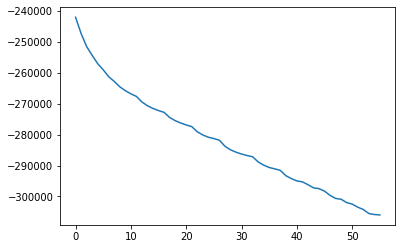

In [29]:
%%time
import matplotlib.pyplot as plt
plt.plot(auto_param_obj_history[1])

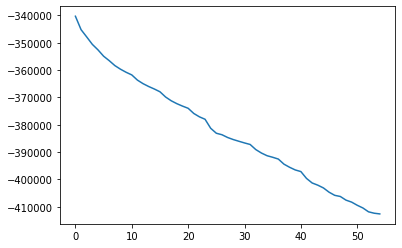

In [24]:
plt.plot(auto_param_relaxed_obj_history[1][3:])

In [32]:
len(T_list)

1

In [33]:
len(H)

11911

In [35]:
H[].shape

(1, 2289)

In [36]:
np.sum([h.shape[0] for h in H])

11911